In [1]:
from PIL import Image
import imageio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from scipy import ndimage as ndi
from skimage import feature
from skimage.color import rgb2gray
%matplotlib inline
from skimage import io

In [2]:
im =cv2.imread('cropped_test.jpg')
hsv=cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
figure_size = 9
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)



print('Original image')
print('Shape of the image : {}'.format(im.shape))
print('Image Hight {}'.format(im.shape[0]))
print('Image Width {}'.format(im.shape[1]))
print('Dimension of Image {}'.format(im.ndim))
print()
print()

print('Grayscale image')
print('Shape of the image : {}'.format(gray.shape))
print('Image Hight {}'.format(gray.shape[0]))
print('Image Width {}'.format(gray.shape[1]))
print('Dimension of Image {}'.format(gray.ndim))

Original image
Shape of the image : (981, 1487, 3)
Image Hight 981
Image Width 1487
Dimension of Image 3


Grayscale image
Shape of the image : (981, 1487)
Image Hight 981
Image Width 1487
Dimension of Image 2


## Denoising 

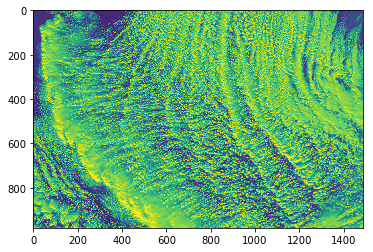

In [3]:
gray_denoised = cv2.fastNlMeansDenoising(gray,10,10,7,21)
plt.imshow(gray_denoised)

## Median/Mean Blur low-pass filter on the denoised Image 
> I did not really see the huge difference between using either so have left both on here. The commented one is median, currently mean is being implemented. (Haven't renamed the variable since it is used below :P)

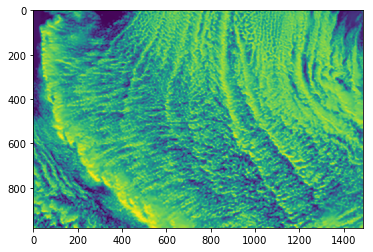

In [4]:
# median_image = cv2.medianBlur(gray_denoised, figure_size)
# plt.imshow(median_image)

median_image = cv2.blur(gray_denoised, (figure_size, figure_size))
plt.imshow(median_image)

## Open with CV2 + Sobel Edge

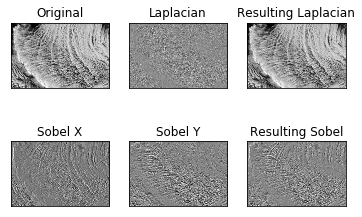

In [5]:
# convolute with proper kernels
laplacian = cv2.Laplacian(median_image,cv2.CV_64F)
sobelx = cv2.Sobel(median_image,cv2.CV_64F,1,0,ksize=17)  # x
sobely = cv2.Sobel(median_image,cv2.CV_64F,0,1,ksize=17)  # y


plt.subplot(2,3,1),plt.imshow(median_image,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,3),plt.imshow(median_image+laplacian,cmap = 'gray')
plt.title('Resulting Laplacian'), plt.xticks([]), plt.yticks([])

plt.subplot(2,3,4),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,5),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
plt.subplot(2,3,6),plt.imshow(median_image+sobelx+sobely,cmap = 'gray')
plt.title('Resulting Sobel'), plt.xticks([]), plt.yticks([])

plt.show()

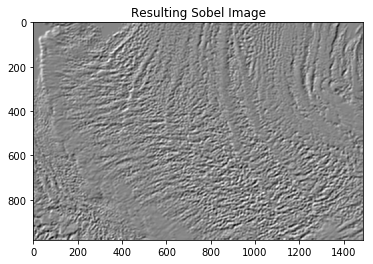

In [6]:
resulting_sobel=median_image+sobelx+sobely
plt.imshow(resulting_sobel,cmap = 'gray')
plt.title("Resulting Sobel Image")
plt.imsave("sobel_test1", resulting_sobel, cmap='Greys')

## Scipy cluster detection on the Sobel image

Number of clusters is 506


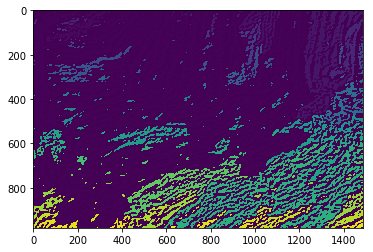

In [7]:
mask = resulting_sobel > resulting_sobel.mean() +10   # mask those pixels whose intensity is above mean
label_im, nb_labels = ndi.label(mask)   # connected components form clusters
print(f"Number of clusters is {nb_labels}")
plt.imshow(label_im);

## Alternative Edges function - coloured image

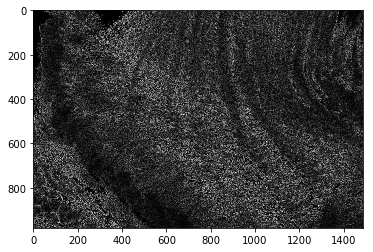

In [8]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

#define the vertical filter
vertical_filter = [[-1,-2,-1], [0,0,0], [1,2,1]]

#define the horizontal filter
horizontal_filter = [[-1,0,1], [-2,0,2], [-1,0,1]]

#read in the image
img = plt.imread('cropped_test.jpg')

#get the dimensions of the image
n,m,d = img.shape

#initialize the edges image
edges_img = img.copy()

#loop over all pixels in the image
for row in range(3, n-2):
    for col in range(3, m-2):
        
        #create little local 3x3 box
        local_pixels = img[row-1:row+2, col-1:col+2, 0]
        
        #apply the vertical filter
        vertical_transformed_pixels = vertical_filter*local_pixels
        #remap the vertical score
        vertical_score = vertical_transformed_pixels.sum()/4
        
        #apply the horizontal filter
        horizontal_transformed_pixels = horizontal_filter*local_pixels
        #remap the horizontal score
        horizontal_score = horizontal_transformed_pixels.sum()/4
        
        #combine the horizontal and vertical scores into a total edge score
        edge_score = (vertical_score**2 + horizontal_score**2)**.5
        
#         print(img.shape)
#         print([edge_score]*3)
#         print(edges_img[row, col])
        #insert this edge score into the edges image
        edges_img[row, col] = [edge_score]*3

#remap the values in the 0-1 range in case they went out of bounds
edges_img = edges_img/edges_img.max()
plt.imshow(edges_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of clusters is 21152


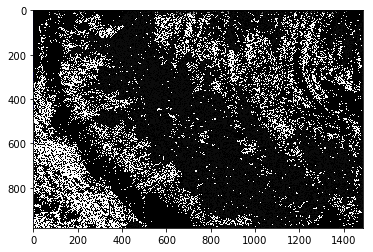

In [9]:
mask = edges_img > edges_img.mean()   # mask those pixels whose intensity is above mean
label_im, nb_labels = ndi.label(mask)   # connected components form clusters
print(f"Number of clusters is {nb_labels}")
plt.imshow(label_im);

## Alternative Edges function - grayscale image

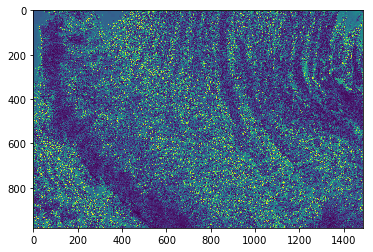

In [10]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

#define the vertical filter
vertical_filter = [[-1,-2,-1], [0,0,0], [1,2,1]]

#define the horizontal filter
horizontal_filter = [[-1,0,1], [-2,0,2], [-1,0,1]]


#get the dimensions of the image
n,m = median_image.shape

#initialize the edges image
edges_img = median_image.copy()

#loop over all pixels in the image
for row in range(3, n-2):
    for col in range(3, m-2):
        
        #create little local 3x3 box
        local_pixels = img[row-1:row+2, col-1:col+2]
        
        #apply the vertical filter
        vertical_transformed_pixels = vertical_filter*local_pixels
        #remap the vertical score
        vertical_score = vertical_transformed_pixels.sum()/4
        
        #apply the horizontal filter
        horizontal_transformed_pixels = horizontal_filter*local_pixels
        #remap the horizontal score
        horizontal_score = horizontal_transformed_pixels.sum()/4
        
        #combine the horizontal and vertical scores into a total edge score
        edge_score = (vertical_score**2 + horizontal_score**2)**.5
        
#         print(img.shape)
#         print([edge_score])
#         print(edges_img[row,col])
        #insert this edge score into the edges image
        edges_img[row, col] = edge_score

#remap the values in the 0-1 range in case they went out of bounds
edges_img = edges_img/edges_img.max()
plt.imshow(edges_img)

Number of clusters is 33747


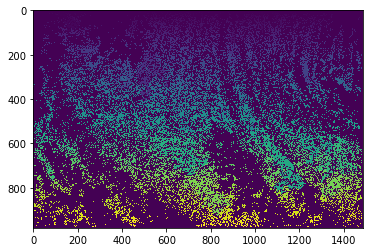

In [11]:
mask = edges_img > edges_img.mean()   # mask those pixels whose intensity is above mean
label_im, nb_labels = ndi.label(mask)   # connected components form clusters
print(f"Number of clusters is {nb_labels}")
plt.imshow(label_im);